# Hierarchical Attention Network Approach

Making use of Attention and internal structure of the toxic comments

Paper: http://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf.

Code was combined from available sources:
* https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2
* https://github.com/richliao/textClassifier 

In [46]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
np.random.seed(42)

import os
import sys
from keras import backend as K
from keras.layers import Dense,Input, LSTM, Bidirectional, Embedding, TimeDistributed, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import Model
from keras.optimizers import Adam
from keras import losses
from keras import initializers as initializers, regularizers, constraints
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
import nltk
import re
from keras.engine.topology import Layer

import warnings
warnings.filterwarnings('ignore')

print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['jigsaw-toxic-comment-classification-challenge', 'glove6b200d', 'glove840b300dtxt', 'toxic-comments-french-spanish-german-train']


## Importing the Embedding and Data files

 * Using the augmented dataset here for all three languages
 * Using the GloVE 200-D word embeddings


In [146]:
#Embedding file
EMBEDDING_FILE = '../input/glove6b200d/glove.6B.200d.txt'

#Training Files
train_en = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv')
train_fr = pd.read_csv('../input/toxic-comments-french-spanish-german-train/train_fr.csv')
train_de = pd.read_csv('../input/toxic-comments-french-spanish-german-train/train_de.csv')
train_es = pd.read_csv('../input/toxic-comments-french-spanish-german-train/train_es.csv')
train = train_en.append(train_es.append(train_de.append(train_fr, ignore_index=True), ignore_index=True), ignore_index=True)

#Testing Files
test = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv')

## Extracting text and the comment tags from the dataframe



In [147]:
#Extracting the comments and removing the Empty comments and storing it as a numpy array 
list_sentences_train = train["comment_text"].fillna("_na_").values
list_sentences_test = test["comment_text"].fillna("_na_").values

list_classes = ["toxic","severe_toxic", "obscene", "threat", "insult", "identity_hate"]

#Storing the sentences as a list
X_train = train["comment_text"].str.lower()
y_train = train[list_classes].values
X_test = test["comment_text"].str.lower()

In [148]:
#List of comments
X_train = list(X_train)
X_test = list(X_test)

In [149]:
#Cleanup is needed to remove the special characters and the unnecessary spaces or newlines
X_train[1]

"d'aww! he matches this background colour i'm seemingly stuck with. thanks.  (talk) 21:51, january 11, 2016 (utc)"

# Preparing Text Data

## Data Cleanup

On noticing the above data we can see that the text data needs cleaning. 
The various cleanup steps applied are:

* Noise Removal, wherein we remove the unnecessary whitespaces and numerals from the text
* Replace certain commonly used phrases and symbols with words that closely resemble them
* Adjust text such as www as https which dont mean anything



In [ ]:
#Removes unwanted symbols and whitespace from the text
def remove_noise(input_text):
    text = re.sub('[\\t\\n\\r\\f\\v]','',input_text) #Removes unnecessary whitespaces
    #text = re.sub(r'[^\w\s]','',text) #Removes all special characters like colons
    text = text.split()
    text = [re.sub('[\d]+','',x) for x in text] #Removes numbers
    return ' '.join(text) #Joins it back

#Apply it to training and testing set
for i in range(len(X_train)):
    X_train[i] = remove_noise(X_train[i])
for i in range(len(X_test)):
    X_test[i] = remove_noise(X_test[i])

In [151]:
X_train[1] #Clean Text

"d'aww! he matches this background colour i'm seemingly stuck with. thanks. (talk) :, january ,  (utc)"

In [154]:
#Replace some of the commonly occuring phrases and emojis with standard text 
#Text is closest in meaning to the emotion being expressed by the phrase or emoji

def replace_word(X):
    repl = {
        "im" : " I am","&lt;3": " good ",":d": " good ",":dd": " good ",":p": " good ","8)": " good ",":-)": " good ", ":)": " good ",";)": " good ",
        "(-:": " good ","(:": " good ","yay!": " good ","yay": " good ","yaay": " good ","yaaay": " good ","yaaaay": " good ",
        "yaaaaay": " good ",":/": " bad ",":&gt;": " sad ",":')": " sad ",":-(": " bad ",":(": " bad ", ":s": " bad ",":-s": " bad ",
        "&lt;3": " heart ",":d": " smile ",":p": " smile ",":dd": " smile ","8)": " smile ", ":-)": " smile ", ":)": " smile ",
        ";)": " smile ","(-:": " smile ","(:": " smile ",":/": " worry ",":&gt;": " angry ", ":')": " sad ",":-(": " sad ",":(": " sad ",
        ":s": " sad ", ":-s": " sad ",r"\br\b": "are",r"\bu\b": "you",r"\bhaha\b": "ha",r"\bhahaha\b": "ha",r"\bdon't\b": "do not",
        r"\bdoesn't\b": "does not",r"\bdidn't\b": "did not",r"\bhasn't\b": "has not",r"\bhaven't\b": "have not",r"\bhadn't\b": "had not",
        r"\bwon't\b": "will not",r"\bwouldn't\b": "would not",r"\bcan't\b": "can not",r"\bcannot\b": "can not",r"\bi'm\b": "i am",
        "m": "am","r": "are","u": "you","haha": "ha","hahaha": "ha","don't": "do not","doesn't": "does not","didn't": "did not",
        "hasn't": "has not","haven't": "have not","hadn't": "had not","won't": "will not","wouldn't": "would not","can't": "can not",
        "cannot": "can not","i'm": "i am","m": "am","i'll" : "i will","its" : "it is","it's" : "it is","'s" : " is","that's" : "that is",
        "weren't" : "were not"
    }
    keys = repl.keys()
    new_X = []
    for i in X:
        arr = str(i).split()
        xx = ""
        for j in arr:
            j = str(j).lower()
            if j[:4] == 'http' or j[:3] == 'www':
                continue
            if j in keys:
                j = repl[j]
            xx += j + " "
        new_X.append(xx)
    return new_X

X_train = replace_word(X_train)
X_test = replace_word(X_test)

In [155]:
X_train[1]

"d'aww! he matches this background colour i am seemingly stuck with. thanks. (talk) :, january , (utc) "

In [156]:
#Maximum number of words
max_features=200000
#Maximum length of a sentence
max_senten_len=40
#Maximum length of a comment
max_senten_num=10
#Dimension of an embedding vector for the word representation
embed_size=200

## Sentence Tokenization

To work with the Hierarchical Attention Network, we need to establish a certain paradigm of hierarchy in the data.
We do so by introducing the following hierarchy:

* Words -> Sentences
* Sentences -> Comments/Documents

This hierarchy is used to establish the context learning via attention mechanism.
We first tokenize the data as sentences and ensure that each comment is represented as a list of sentences and that each sentence is represented as a list of words.

In [157]:
#Need to represent each comment as a list of sentences
#Each comment can have a maximum of 5 sentences and each sentence can have a maximum of 40 words
#Embedding size used is 200

#The Following code block basically takes up a comment and assigns each comment to a 5-length list
#Each element of the list is a sentence
def filt_sent(X,max_senten_num):
    X_sent = []
    sent_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    for paragraph in X:
        raw = sent_tokenizer.tokenize(paragraph)
        filt = []
        min_sent_len = 10 if len(raw) <= 10 else 10
        for sentence in raw:
            if len(sentence.split()) >= min_sent_len and len(filt) < max_senten_num:
                filt.append(sentence)
        while len(filt) < max_senten_num:
            filt.append('_nan_')
        X_sent.append(filt)
    return X_sent

### Sentence Tokenization Details:

We assign the maximum sentence length as 10 based on the reasoning that most sentences are of length less than 10.
This can be seen from the visualization and analysis done here.

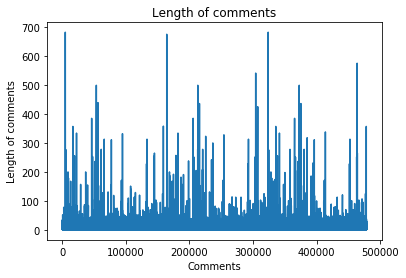

In [142]:
s_t = nltk.data.load('tokenizers/punkt/english.pickle')
counts = []

for i in range(len(X_train)):
    raw = s_t.tokenize(X_train[i])
    counts.append(len(raw))

plt.plot(counts)
plt.xlabel("Comments")
plt.ylabel("Length of comments")
plt.title("Length of comments")
plt.show()

In [158]:
#Getting a list of lists where each of the inner lists is a 10-d list of sentences
X_train_sent = filt_sent(X_train ,max_senten_num)
X_test_sent = filt_sent(X_test, max_senten_num)

In [162]:
X_train_sent[1]
#len(X_train_sent[1])

['he matches this background colour i am seemingly stuck with.',
 '_nan_',
 '_nan_',
 '_nan_',
 '_nan_',
 '_nan_',
 '_nan_',
 '_nan_',
 '_nan_',
 '_nan_']

### Word tokenization

* Now we use the entire training and test vectors to tokenize the words.
* This tokenization technique ensures that each word has an index associated with it.


In [163]:
#Need to tokenize words now
tok=text.Tokenizer(num_words=max_features,lower=True)
#Tokenizes on the combined corpus of train and text
tok.fit_on_texts(list(X_train)+list(X_test))
for i in range(len(X_train_sent)):
        X_train_sent[i] = tok.texts_to_sequences(X_train_sent[i])
        X_train_sent[i] = sequence.pad_sequences(X_train_sent[i],maxlen=max_senten_len) #padding to ensure similar sized representation for each sentence
for i in range(len(X_test_sent)):
        X_test_sent[i] = tok.texts_to_sequences(X_test_sent[i])
        X_test_sent[i] = sequence.pad_sequences(X_test_sent[i],maxlen=max_senten_len) #padding to ensure similar sized representation for each sentence

In [164]:
#A dictionary of the words and indices based on the above text corpus
word_index = tok.word_index
len(word_index)

486379

In [165]:
print(word_index["thanks"],word_index["good"],word_index["hate"], sep=" ; ")

113 ; 84 ; 373


In [166]:
X_train_sent[1][0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,   47, 2800,   14,
        484, 6737,    4,   40, 4754, 1194,   23], dtype=int32)

## Embedding Matrix Generation

* We use the GloVE 200-dimensional word embedding trained on Wikipedia crawl data
* For words that are not present in the Embedding file, they are assigned a random embedding vector based on a normalised distribution of the glove file
* At the end of this section we will have the embedding matrix of length Max-features which is 200k

In [167]:
embeddings_index={}

f = open(EMBEDDING_FILE)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Found %s word vectors.'%len(embeddings_index))

Found 400000 word vectors.


In [168]:
all_embeddings = np.stack(embeddings_index.values())

emb_mean= all_embeddings.mean()
emb_stddev = all_embeddings.std()

np.shape(all_embeddings)

(400000, 200)

In [169]:
#prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.random.normal(emb_mean, emb_stddev, (num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
np.shape(embedding_matrix)

(200000, 200)

## Hierarchical Attention Model

In [170]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [171]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [172]:
embedding_layer = Embedding(max_features,
                            embed_size,
                            input_length=max_senten_len,
                            weights=[embedding_matrix])

word_input = Input(shape=(max_senten_len,), dtype='int32')
word = embedding_layer(word_input)
word = SpatialDropout1D(0.2)(word)
word = Bidirectional(LSTM(128, return_sequences=True))(word)
word_out = AttentionWithContext()(word)
wordEncoder = Model(word_input, word_out)

sente_input = Input(shape=(max_senten_num, max_senten_len), dtype='int32')
sente = TimeDistributed(wordEncoder)(sente_input)
sente = SpatialDropout1D(0.2)(sente)
sente = Bidirectional(LSTM(128, return_sequences=True))(sente)
sente = AttentionWithContext()(sente)
preds = Dense(6, activation='sigmoid')(sente)
model = Model(sente_input, preds)
opt = Adam(clipnorm=5.0)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

In [173]:
X_train_sent = np.asarray(X_train_sent)
X_test_sent = np.asarray(X_test_sent)
print('Shape of data tensor:', X_train_sent.shape)

Shape of data tensor: (638284, 10, 40)


In [174]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 10, 40)            0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 256)           40402944  
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 10, 256)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 10, 256)           394240    
_________________________________________________________________
attention_with_context_6 (At (None, 256)               66048     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1542      
Total params: 40,864,774
Trainable params: 40,864,774
Non-trainable params: 0
________________________________________________________________

In [175]:
batch_size = 256
epochs = 5

X_tra, X_val, y_tra, y_val = train_test_split(X_train_sent, y_train, train_size=0.95, random_state=233)
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)
filepath="weights_base.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
early = EarlyStopping(monitor="val_acc", mode="max", patience=5)
callbacks_list = [checkpoint, early, RocAuc]

history = model.fit(X_tra, y_tra, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),callbacks = callbacks_list, verbose=1)

Train on 606369 samples, validate on 31915 samples
Epoch 1/5
606369/606369 [==============================] - 1424s 2ms/step - loss: 0.0919 - acc: 0.9713 - val_loss: 0.0778 - val_acc: 0.9740

Epoch 00001: val_acc improved from -inf to 0.97401, saving model to weights_base.best.hdf5

 ROC-AUC - epoch: 1 - score: 0.934580 

Epoch 2/5
606369/606369 [==============================] - 1413s 2ms/step - loss: 0.0727 - acc: 0.9758 - val_loss: 0.0707 - val_acc: 0.9763

Epoch 00002: val_acc improved from 0.97401 to 0.97634, saving model to weights_base.best.hdf5

 ROC-AUC - epoch: 2 - score: 0.945815 

Epoch 3/5
606369/606369 [==============================] - 1413s 2ms/step - loss: 0.0655 - acc: 0.9782 - val_loss: 0.0665 - val_acc: 0.9779

Epoch 00003: val_acc improved from 0.97634 to 0.97791, saving model to weights_base.best.hdf5

 ROC-AUC - epoch: 3 - score: 0.950674 

Epoch 4/5
606369/606369 [==============================] - 1414s 2ms/step - loss: 0.0598 - acc: 0.9803 - val_loss: 0.0646 - 

In [177]:
y_pred = model.predict(X_test_sent,batch_size=1024,verbose=1)

153164/153164 [==============================] - 69s 452us/step


In [179]:
'''submission = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv')
submission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred
submission.to_csv('submission.csv', index=False)'''

'submission = pd.read_csv(\'../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv\')\nsubmission[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]] = y_pred\nsubmission.to_csv(\'submission.csv\', index=False)'

## Plotting Model Accuracy and Loss

One can see that the Model begins to overfit by the end of the third epoch

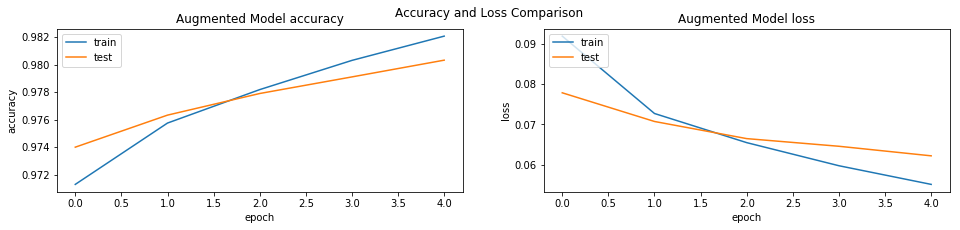

In [178]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#print(history.history.keys())


plt.figure(figsize=(16,3))
plt.suptitle('Accuracy and Loss Comparison')

gridspec.GridSpec(1,2)
plt.subplot2grid((1,2),(0,0))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Augmented Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'],loc='upper left')


plt.subplot2grid((1,2),(0,1))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Augmented Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'],loc='upper left')